In [93]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot


from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from detectron2.structures.masks import polygons_to_bitmask

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC
ac_acdc_env  local	output		  requirements.txt  utils
al_output    log	pipeline_configs  shell_scripts     wandb
data	     notebooks	README.md	  src


In [2]:
dataset = ACDC_LARGE_CLS
config_name = "classes_acdc_large_al"

model_path = "/home/florian/GitRepos/activeCell-ACDC/al_output/classes_acdc_large_al/random"

register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][1]
))

train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

registering acdc_small dataset
registering acdc_large dataset
registering acdc_large_cls dataset


In [191]:
def plot_gt(image_id, data_json):
    cfg = get_cfg()
    cfg.DATASETS.TRAIN = get_dataset_name(dataset, DATASETS_DSPLITS[dataset][0])
    in_image_json = list(
        filter(lambda image_json: image_json["image_id"] == image_id, data_json)
    )[0]
    in_image = cv2.imread(in_image_json["file_name"])  # imgs[0]
    visualizer = Visualizer(
        in_image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
        scale=2,
    )
    out = visualizer.draw_dataset_dict(in_image_json)
    out_image = out.get_image()[:, :, ::-1]
    show_image(out_image)


def plot_hist(array):
    sns.set_context("talk")
    a4_dims = (20, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.histplot(data=np.array(array))
    plt.xlabel('Volume of cells in pixels')

def plot_hist_experiments(data_df):
    sns.set_context("talk")
    a4_dims = (20, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    g = sns.histplot(data=data_df, x="pixel_vol", hue="Experiment")
    plt.xlabel('Volume of cells in pixels')



def plot_hist_class(data_df):
    sns.set_context("talk")
    a4_dims = (20, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.histplot(data=data_df, x="pixel_vol", hue="Cell Cycle Stage")
    plt.xlabel('Volume of cells in pixels')

## Data Set Sizes

In [35]:
print(f"total images: \t {len(test_data) + len(train_data)}")
print(f"train images: \t {len(train_data)}")
print(f"test images: \t {len(test_data)}")

total images: 	 7321
train images: 	 5803
test images: 	 1518


In [57]:
def get_exp_dict(data_jsons):
    pos_dict = {}

    for image_json in data_jsons:
        id = image_json["image_id"]
        num_objects = len(image_json["annotations"])
        experiment = id.split("_pos")[0]
        frame_id = id.split("_")[-1]
        position = "_".join(id.replace(f"{experiment}_","").split("_")[:-1])

        if position.find("_") == -1:
            print(id)

        if experiment in pos_dict.keys():
            if position in pos_dict[experiment].keys():
                pos_dict[experiment][position].append([frame_id, num_objects])
            else:
                pos_dict[experiment][position] = [[frame_id, num_objects]]
        else:
            pos_dict[experiment] = {position:[[frame_id, num_objects]]}

    return pos_dict

total_data = train_data + test_data
total_pos_dict = get_exp_dict(total_data)
train_pos_dict = get_exp_dict(train_data)
test_pos_dict = get_exp_dict(test_data)

In [58]:

def print_dict_info(pos_dict):
    total_pos = 0
    for experiment in list(pos_dict.keys()):
        print(experiment, "num positions: ", len(list(pos_dict[experiment].keys())))
        total_pos += len(list(pos_dict[experiment].keys()))
        #for position in list(pos_dict[experiment].keys()):
            #print("\t", position, "num frames: ", len(pos_dict[experiment][position]))
    print(f"num pos: {total_pos}")

In [59]:
print("\ntotal:")
print_dict_info(total_pos_dict)



total:
TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_labeled num positions:  2
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled num positions:  5
acdc_data2_F016 num positions:  4
acdc_data2_beer_experiment1 num positions:  2
acdc_data2_kurt_306-3_0_20201028 num positions:  3
acdc_data2_kurt_306-3_20_20201105 num positions:  2
acdc_data3_20210722 num positions:  6
acdc_data3_20211029 num positions:  6
acdc_data3_Yagya_SCD_WT num positions:  6
acdc_data3_Yagya_SCGE_WT num positions:  7
num pos: 43


In [60]:
print("train:")
print_dict_info(train_pos_dict)

train:
TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_labeled num positions:  2
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled num positions:  4
acdc_data2_F016 num positions:  3
acdc_data2_beer_experiment1 num positions:  2
acdc_data2_kurt_306-3_0_20201028 num positions:  2
acdc_data2_kurt_306-3_20_20201105 num positions:  2
acdc_data3_20210722 num positions:  3
acdc_data3_20211029 num positions:  4
acdc_data3_Yagya_SCD_WT num positions:  4
acdc_data3_Yagya_SCGE_WT num positions:  7
num pos: 33


In [61]:
print("test:")
print_dict_info(test_pos_dict)

test:
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled num positions:  1
acdc_data2_F016 num positions:  1
acdc_data2_kurt_306-3_0_20201028 num positions:  1
acdc_data3_20210722 num positions:  3
acdc_data3_20211029 num positions:  2
acdc_data3_Yagya_SCD_WT num positions:  2
num pos: 10


## Objects

In [72]:

def get_object_info(pos_dict):
    total_objects = 0
    objects_list = []
    min_obj_list = []
    max_obj_list = []
    for experiment in list(pos_dict.keys()):
        for position in list(pos_dict[experiment].keys()):
            min_frame_id = 10000
            max_frame_id = 0
            min_frame_num_obj = -1
            max_frame_num_obj = -1
            for frame_id, num_objects in pos_dict[experiment][position]:
                total_objects += num_objects
                objects_list.append(num_objects)

                if int(frame_id) < min_frame_id:
                    min_frame_id = int(frame_id)
                    min_frame_num_obj = num_objects


                if int(frame_id) > max_frame_id:
                    max_frame_id = int(frame_id)
                    max_frame_num_obj = num_objects
            min_obj_list.append(min_frame_num_obj)
            max_obj_list.append(max_frame_num_obj)
            
    print("total objects: ", total_objects)
    print("mean objects: ", sum(objects_list)/len(objects_list))
    print("min objects: ", min(objects_list))
    print("max objects: ", max(objects_list))
    print("average first frame:", sum(min_obj_list)/len(min_obj_list))
    print("average last frame:", sum(max_obj_list)/len(max_obj_list))


get_object_info(total_pos_dict)

total objects:  125794
mean objects:  17.182625324409234
min objects:  1
max objects:  85
average first frame: 5.023255813953488
average last frame: 45.2093023255814


## Image Size

In [74]:
min_w = 10000
max_w = 0
min_h = 10000
max_h = 0
for image_json in total_data:

    w = image_json["width"]
    h = image_json["height"]

    max_w = max(max_w , w)
    max_h = max(max_h , h)

    min_w = min(min_w , w)
    min_h = min(min_h , h)

print("w", min_w, max_w)
print("h", min_h, max_h)

w 170 1024
h 143 1024


## Object Shapes

In [192]:
records = []

for image_json in tqdm(total_data):
    w = image_json["width"]
    h = image_json["height"]

    id = image_json["image_id"]
    experiment = id.split("_pos")[0]

    for obj in image_json["annotations"]:
        pixel_vol = polygons_to_bitmask(polygons=obj["segmentation"], height=h, width=w).sum()

        records.append({
            "id": id,
            "Experiment": experiment,
            "pixel_vol":pixel_vol
        })
        


cell_volume_df = pd.DataFrame.from_records(records)

cell_volume_df.head()


100%|██████████| 7321/7321 [00:40<00:00, 182.48it/s] 


,id,Experiment,pixel_vol
0,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,664
1,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,463
2,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,27
3,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,651
4,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,449


In [193]:
print("min volume:", min(cell_volume_df["pixel_vol"].values))
print("max volume:", max(cell_volume_df["pixel_vol"].values))
print("mean volume:", sum(cell_volume_df["pixel_vol"].values)/len(cell_volume_df["pixel_vol"].values))

min volume: 0
max volume: 24396
mean volume: 2185.4554827734232


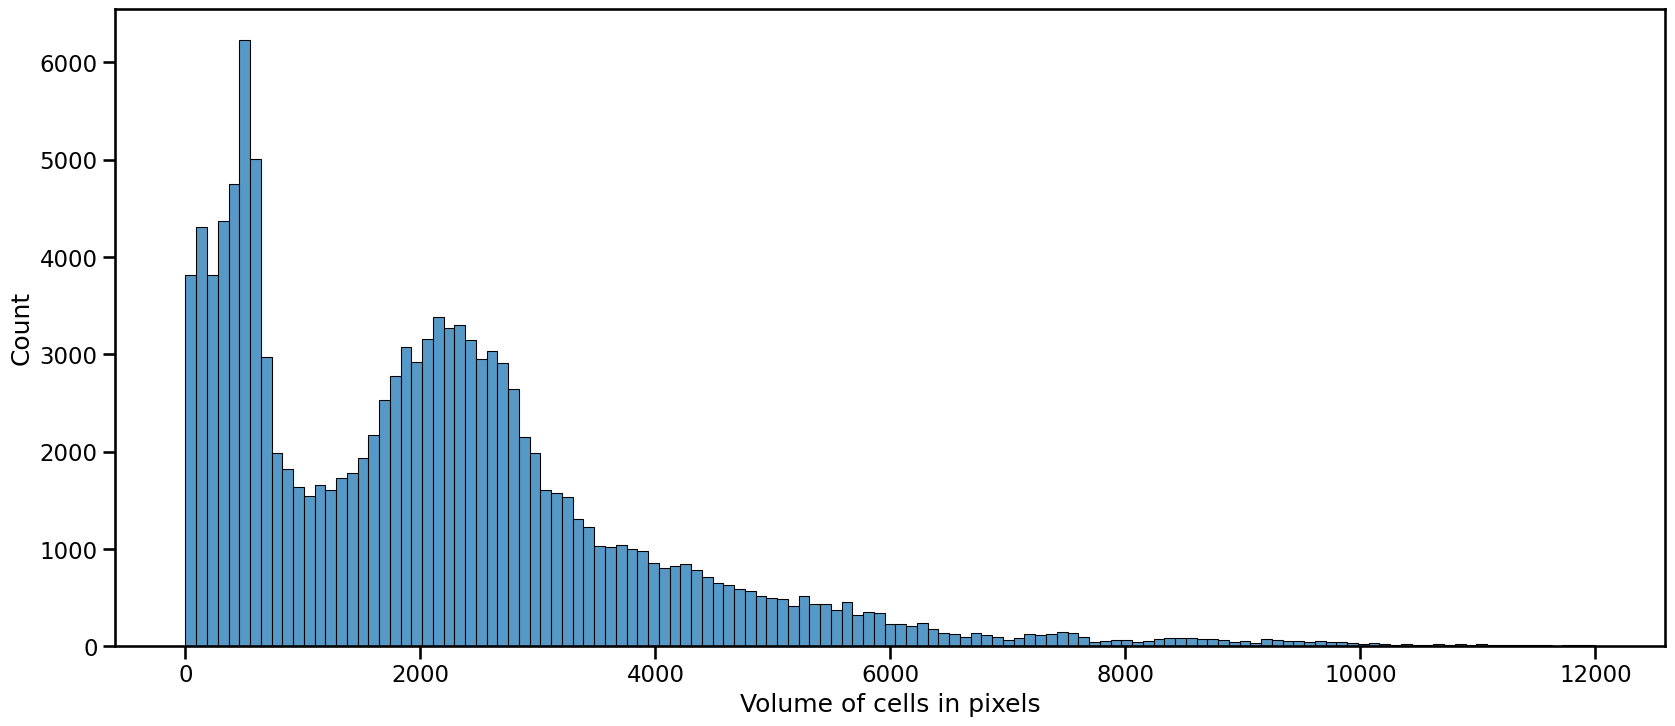

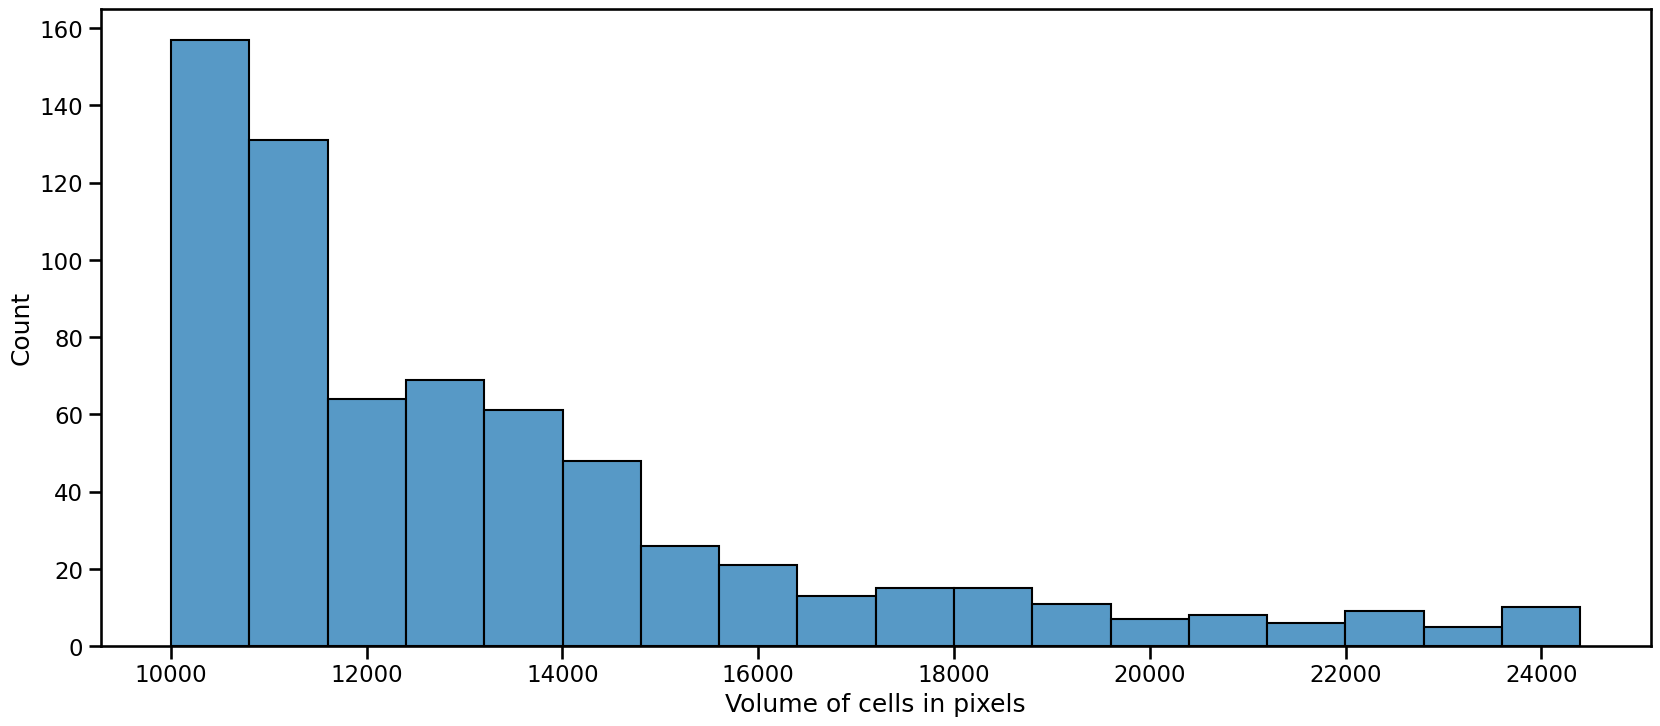

In [194]:
plot_hist(cell_volume_df[cell_volume_df["pixel_vol"] <= 12000]["pixel_vol"].values)
plot_hist(cell_volume_df[cell_volume_df["pixel_vol"] >= 10000]["pixel_vol"].values)


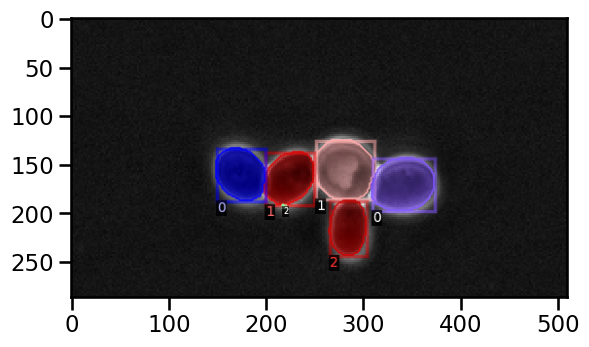

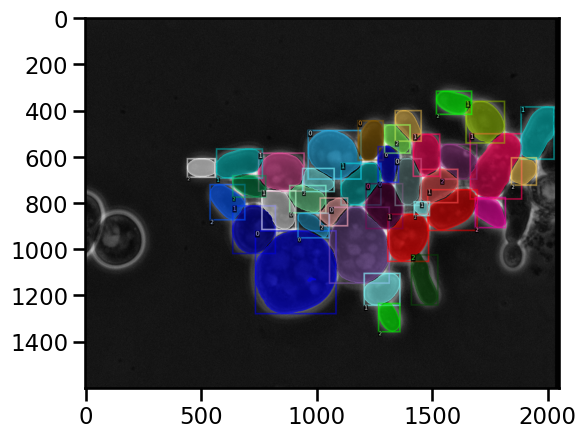

In [195]:
plot_gt(cell_volume_df[cell_volume_df["pixel_vol"] == cell_volume_df["pixel_vol"].min()]["id"].values[0], total_data)
plot_gt(cell_volume_df[cell_volume_df["pixel_vol"] == cell_volume_df["pixel_vol"].max()]["id"].values[0], total_data)


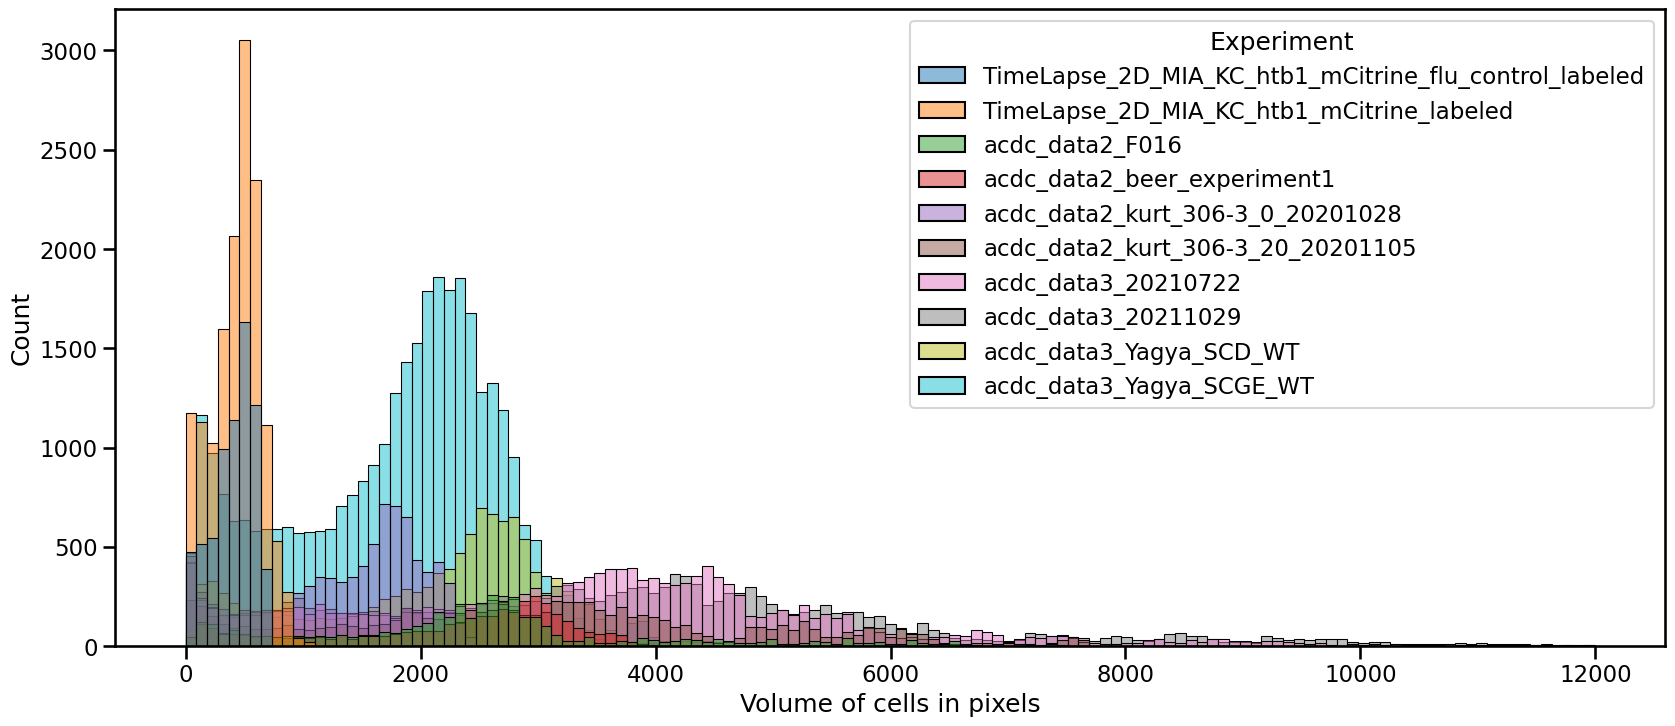

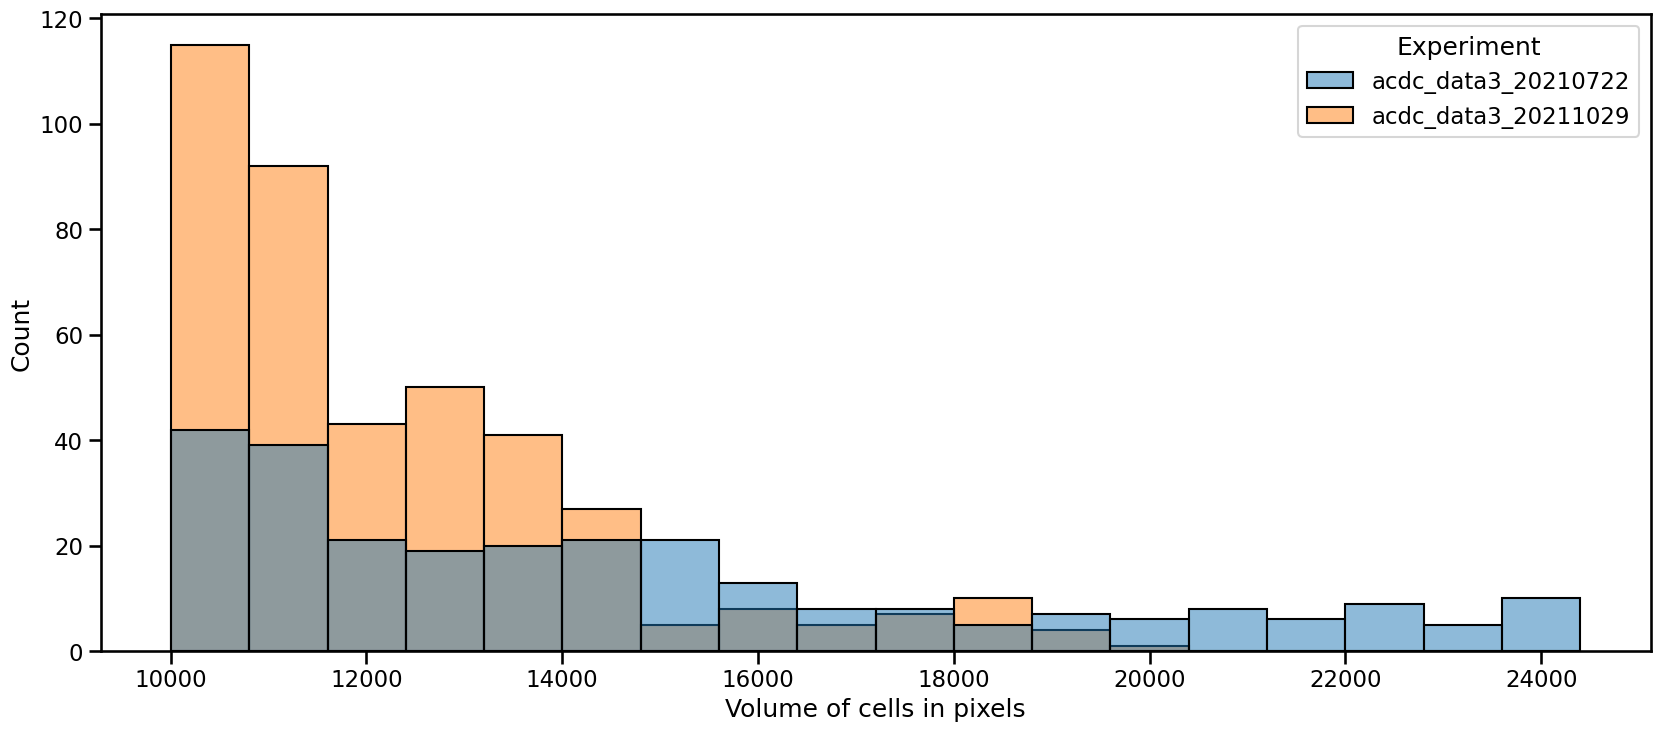

In [196]:

plot_hist_experiments(cell_volume_df[cell_volume_df["pixel_vol"] <= 12000])
plot_hist_experiments(cell_volume_df[cell_volume_df["pixel_vol"] >= 10000])



## Classes

In [197]:
records = []

class_map = {
    0:"G1",
    1:"SG2M-Mother",
    2:"SG2M-Bud",
}

for image_json in tqdm(total_data):
    w = image_json["width"]
    h = image_json["height"]

    id = image_json["image_id"]
    experiment = id.split("_pos")[0]

    for obj in image_json["annotations"]:
        pixel_vol = polygons_to_bitmask(polygons=obj["segmentation"], height=h, width=w).sum()

        obj_class = class_map[obj["category_id"]]
        records.append({
            "id": id,
            "experiment": experiment,
            "pixel_vol":pixel_vol,
            "obj_class": obj_class,
            "Cell Cycle Stage": obj_class,
        })
        


cell_class_df = pd.DataFrame.from_records(records)

cell_class_df.head()

100%|██████████| 7321/7321 [00:40<00:00, 182.43it/s] 


,id,experiment,pixel_vol,obj_class,Cell Cycle Stage
0,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,664,SG2M-Mother,SG2M-Mother
1,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,463,G1,G1
2,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,27,SG2M-Bud,SG2M-Bud
3,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,651,SG2M-Mother,SG2M-Mother
4,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,TimeLapse_2D_MIA_KC_htb1_mCitrine_flu_control_...,449,G1,G1


In [198]:
for c in cell_class_df["obj_class"].unique():
    print(c, len(cell_class_df[cell_class_df["obj_class"] == c]), len(cell_class_df[cell_class_df["obj_class"] == c])/len(cell_class_df), "avg cell size", cell_class_df[cell_class_df["obj_class"] == c]["pixel_vol"].mean())
    print("")

#cell_class_df["obj_class"]

SG2M-Mother 45812 0.3641827114170787 avg cell size 3036.885204749847

G1 34056 0.2707283336248152 avg cell size 2655.583568240545

SG2M-Bud 45926 0.3650889549581061 avg cell size 987.5200975482297



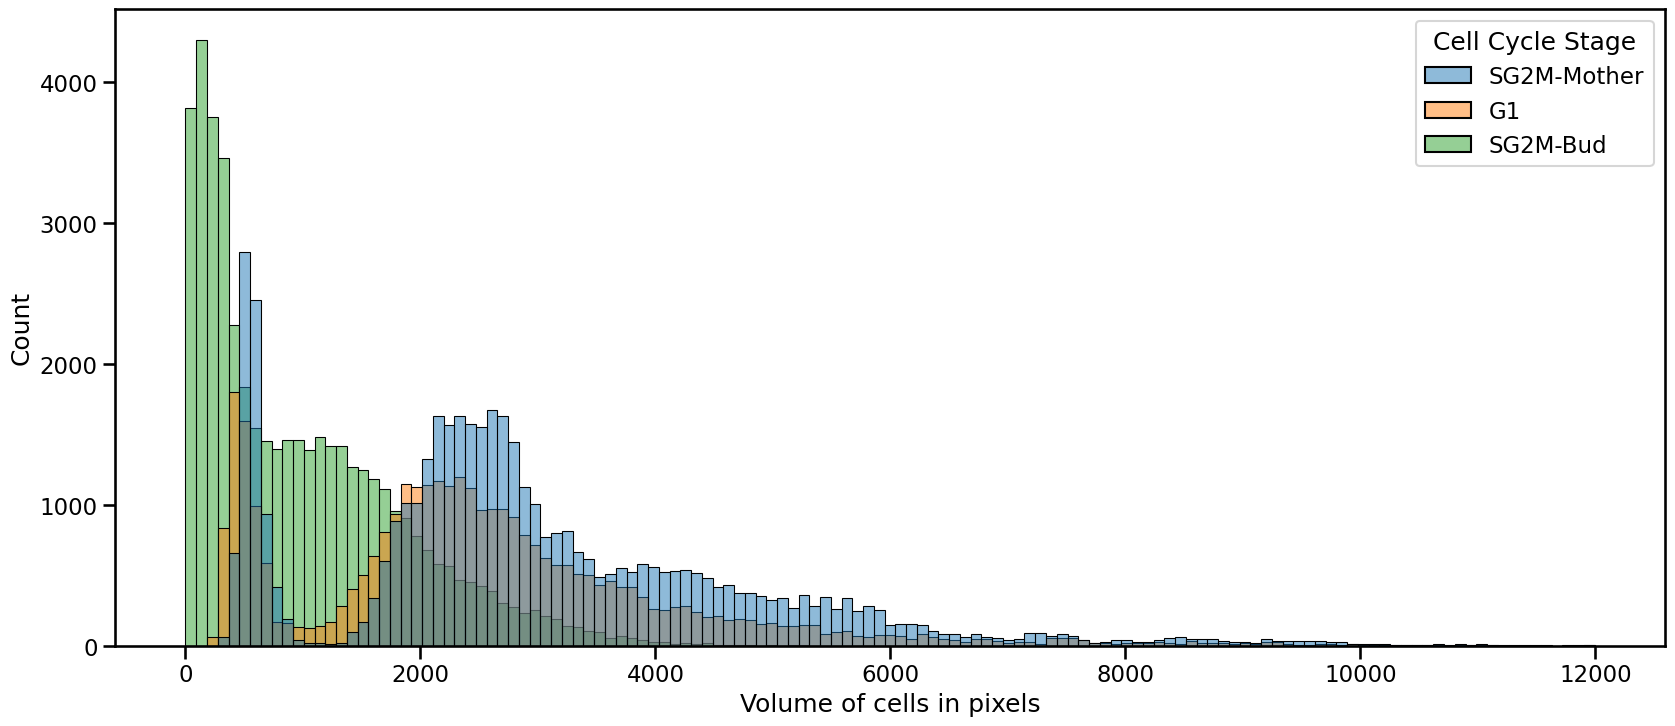

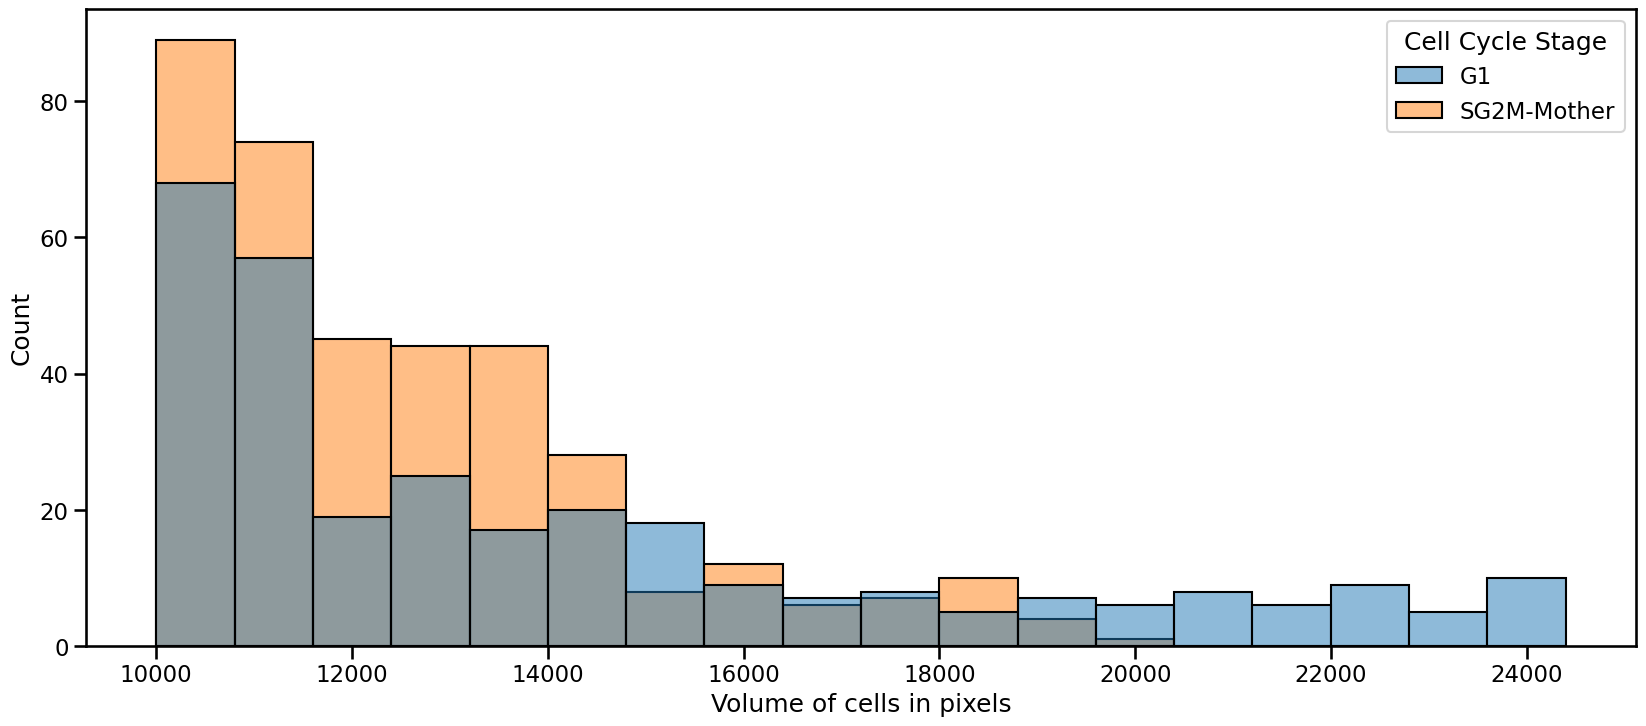

In [199]:
plot_hist_class(cell_class_df[cell_class_df["pixel_vol"] <= 12000])
plot_hist_class(cell_class_df[cell_class_df["pixel_vol"] >= 10000])